<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) deep network,
(2) cost function, (3) method of calculating accuracy,
(4) an image that shows the dense prediction produced by your network on the pos_test_000072.png image.
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 40% Proper implementation of a loss function and train/test set accuracy measure
* 10% Tidy visualizations of loss of your dense predictor during training
* 10% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**



**DONE:**
* Watch tutorial

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

**TODO:**

* Create a Network that classifies each pixel as a 1 or 0 for cancerous / not cancerous

**DONE:**

___

### Part 1a
Implement your network topology


Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties

**DONE:**


___
The intention of this lab is to learn how to make deep neural nets and implement loss function.
Therefore we'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

In [26]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
import cv2
import scipy.misc
from PIL import Image
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return int(len(self.dataset_folder))

___

### Part 1b
Implement a cost function

You should still use cross-entropy as your cost function, but you may need to think hard about how exactly to set this up – your network should output cancer/not-cancer probabilities for each pixel, which can be viewed as a two-class classification problem.

**TODO:**

* Adapt CrossEntropyLoss for 2 class pixel classification

**DONE:**



In [0]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer


You're gonna use the convolution transpose, which has the same layout structure as convolution. Except that instead of thinking about what the input is to what you get an output, you think about what the output is to get an input, in terms of shape size.

**What we did to write the cancer dataset class**
- Remember to shuffle data

PROFILING
You will find that each step of the operation is slow. How to fix it: num_workers in dataloader. By using x workers, you can have x images in your dataloader in the same time that it would have taken to get 1. Take the number of threads you have (unsure about actual number on colab but in general) multiply it by 1.5 and that is a good number for the number of workers. Definitely on the train_loader. Less important on the val_loader. Incur upfront cost of loading imgs using multiple threads, but get a speed up during training.

!nvidia-smi. This function will tell you how much GPU you're using. If you find yourself with low GPU utilization, that means it's taking longer to load your batches than it is to run your batch which means you're bottlenecked by the dataloader. The only way to fix that is to make your dataloader faster or to use more threads. If GPU utilization is high (like in 90% range) then you're basically running at full capacity and the only way to speed things up is to make your model smaller and more efficient. Batches will be small. Model is fixed. Kinda stuck. Do what you can to get any improvement.

Measuring number: iterations per second that you get from tqdm.
Look into gputil. showUtilization() know that it takes longer to run than loading images, thus will slow down it/s if you use it a bunch.
You can increase your batch size to increase utilization. There's a sweet spot in number of steps. If batch size is small, bunch a steps. If batch size is large, not a bunch of steps.
Something called line profiling.

In [0]:
# How to free up GPU memory
# 1. model = model.cuda() not strictly necessary
#    Call model.cuda() instead (stand alone)
#
# 2. Create Scope:(discourages ipynb from using local variables) THIS ONE IS THE MOST IMPORTANT
#    Put ur shit (model initialization and train loop) into a function called scope (or something)
#
# 3. Force the garbage collector to collect the garbage (gc.collect())
#    In practice this only solves part of the problem.
#    Forcing garbage collection at the beginning of train loop will help your memory footprint
#
# 4. Catch exceptions
#    Unhandled exceptions (keyboard interrupt) cause a memory leak
#    Put whole model initialization and train loop in a try statement
#    try:
#        # stuff
#    except Exception | KeyboardInterrupt: # just call except and that will catch all, no need to specify "Exception" or "keyboardInterrupt"
#        __ITB__()
#        
# More tools: 
#    torch.cuda.empty_cache() # this will force empty the gpu
#    print(torch.cuda.memory_allocated(0) / 1e9) # This will print amount of GPU memory being used
#
#
# This is for debugging: 
# It says: grab all objects in garbage collector (gc), if the object is a tensor, print its size
# for obj in gc.get_objects():
#     if torch.is_tensor(obj):
#         print(obj.size())

In [0]:
print(torch.cuda.memory_allocated(0) / 1e9) # This will print amount of GPU memory being used
torch.cuda.empty_cache() # this will force empty the gpu
print(torch.cuda.memory_allocated(0) / 1e9) # This will print amount of GPU memory being used
!nvidia-smi

In [0]:
### How to use something that is not nn.Sequential() 22:00
# Around 24:00 he talks about how another TA made the u-net as a bunch of separate modules
# "You don't need to have all of this in one module, you can split it up into different modules as you deem necessary"

In [0]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.


class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Block, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )
        
    
    def forward(self, input):
#         print(input.shape)
        return self.net(input).squeeze(2).squeeze(2)
    

# TODO: You need to change this to fit the UNet structure!!!
class CancerDetection(nn.Module):
    def __init__(self):
        super(CancerDetection, self).__init__()
        self.block1 = Block(3,64)
        self.block2 = Block(64,128)
        self.block3 = Block(128,256)
        self.block4 = Block(256,512)
        self.block5 = Block(512,512)
        
        # Upsampling layers
        self.convTrans1 = nn.ConvTranspose2d(512,512,kernel_size=2,stride=2,padding=0)
        self.block6 = Block(1024,256)
        self.convTrans2 = nn.ConvTranspose2d(256,256,kernel_size=2,stride=2,padding=0)
        self.block7 = Block(512,128)
        self.convTrans3 = nn.ConvTranspose2d(128,128,kernel_size=2,stride=2,padding=0)
        self.block8 = Block(256,64)
        self.convTrans4 = nn.ConvTranspose2d(64,64,kernel_size=2,stride=2,padding=0)
        self.block9 = Block(128,64)
        self.finalConv = nn.Conv2d(64,2, kernel_size = 1, stride = 1, padding = 0)
        
        self.maxpool2d = nn.MaxPool2d(kernel_size=(2,2), stride = 2, padding = 0)
 

    def forward(self, input):
        # Downsample chunk
        o1 = self.block1(input)
        o2 = self.block2(self.maxpool2d(o1))
        o3 = self.block3(self.maxpool2d(o2))
        o4 = self.block4(self.maxpool2d(o3))
        o5 = self.block5(self.maxpool2d(o4))        
        # Upsample and concatenate chunk
        o6 = self.block6(torch.cat((o4, self.convTrans1(o5)), 1))
        o7 = self.block7(torch.cat((o3, self.convTrans2(o6)), 1))
        o8 = self.block8(torch.cat((o2, self.convTrans3(o7)), 1))
        o9 = self.block9(torch.cat((o1, self.convTrans4(o8)), 1))
        final_o = self.finalConv(o9)

#         print(o1.shape)                                                                                
#         print(o2.shape)
#         print(o3.shape)
#         print(o4.shape)
#         print(o5.shape)
#         print("Upsamples")
#         print(o6.shape)
#         print(o7.shape)
#         print(o8.shape)
#         print(o9.shape)
#         print(final_o.shape)

        return final_o.squeeze(2).squeeze(2)
    


In [0]:
# Create your datasets and neural network as you have before
# Datasets
train_dataset = CancerDataset('/tmp/cancer_train', train=True, size=256)
val_dataset = CancerDataset('/tmp/cancer_test', train=False, size=256)

# Init dataloaders
train_loader = DataLoader(train_dataset,
                          batch_size=20,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=5
                         )
val_loader = DataLoader(val_dataset,
                         batch_size=20,
                         pin_memory=True,
                        )

In [0]:
def get_raw_accuracy(y_hat, y_truth):
    # what we want to do is turn y_hat into a 2d tensor of 0's and 1 to compare to y_truth
    accs = []
    # Acc
    for pred, target in zip(y_hat, y_truth):
        pix_pred = torch.argmax(pred, dim=0).long()
        correct = 1 - torch.abs(pix_pred - target.long())
        acc = torch.mean(correct.float())
        accs.append(acc.item())

    return np.mean(accs)

0.563775488


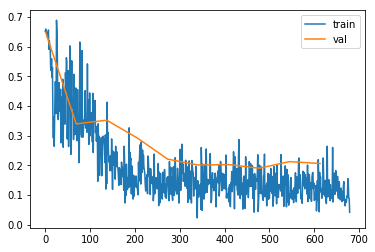

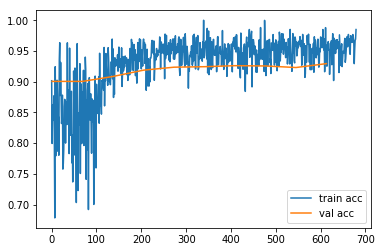

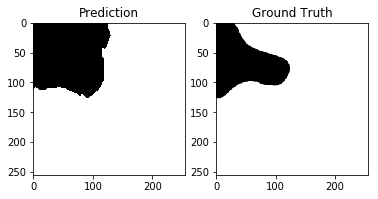

In [55]:
# This is what was talked about in the video for memory management

def scope():
  try:
    losses = []
    accuracies = []
    validations = []
    validation_accs= []
    
    #your code for calling dataset and dataloader
    gc.collect()
    torch.cuda.empty_cache()
    print(torch.cuda.memory_allocated(0) / 1e9)
    
    # Init model
    model = CancerDetection()
    model.cuda()
    # Init optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # Init loss function
    objective = nn.CrossEntropyLoss()
    
    softmax = nn.Softmax2d()
    
    # TRAIN
    #for epochs:
    # Call your model, figure out loss and accuracy
    num_epochs = 10
    for epoch in range(num_epochs):
        loop = tqdm(total=len(train_loader), position=0, leave=False)
        for batch, (x,y_truth) in enumerate(train_loader):
            # 1. Get the actual input and output from train_loader (x, y_truth)
            x = x.cuda(async=True)
            y_truth = y_truth.cuda(async=True)
            y_truth = y_truth.long()
            # 2. Zero gradient the optimizer for some reason (TODO)
            optimizer.zero_grad()

            # 3. Get y_hat (prediction)
            y_hat = model(x)
            
#             # Print prediction
#             torch.cuda.synchronize()
#             img = softmax(y_hat)
#             img = y_hat[0].detach().squeeze().cpu().numpy()
#             img = np.argmax(img, axis=0)
#             plt.subplot(1,2,1)
#             plt.imshow(img, interpolation='nearest', cmap='Greys')
#             plt.rcParams["axes.grid"] = False
#             # Print Ground truth
#             plt.subplot(1,2,2)
#             img1 = y_truth[0].detach().squeeze().cpu().numpy()
#             plt.imshow(img1, interpolation='nearest', cmap='Greys')
#             plt.rcParams["axes.grid"] = False
#             plt.show()

            # 4. Compute loss (y_hat batch,2,h,w --- Y_truth: b, h, w)
            loss = objective(y_hat, y_truth)
            # 5. Backprop (compute gradients)
            loss.backward()
            # 6. Step downhill
            optimizer.step()

            # Housekeeping
            losses.append(loss)
            accuracy = get_raw_accuracy(y_hat, y_truth)
            mem = torch.cuda.memory_allocated(0) / 1e9
            accuracies.append(accuracy)
            loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch, loss, accuracy, mem))
            loop.update(1)

            # Validation Loop (cute and optimized)
            if batch % 500 == 0:
                # compute the loss for all x, y in val_loader, then get the mean of those losses
                val = np.mean([objective(model(x.cuda()), y.cuda().long()).item()
                               for x, y in val_loader
                               ])
                validations.append((len(losses), val))
                
                val_acc = np.mean([get_raw_accuracy(model(x.cuda()), y.cuda().long()).item()
                               for x, y in val_loader
                               ])
                validation_accs.append((len(accuracies), val_acc))
        loop.close()
                
    # PLOT
    # PLOT
    # validations is a list of tuples, this unzips it into two lists
    a, b = zip(*validations)
    plt.plot(losses, label='train')
    plt.plot(a, b, label='val')
    plt.legend()
    plt.show()
    # Show accuracy progression
    a1, b1 = zip(*validation_accs)
    plt.plot(accuracies, label='train acc')
    plt.plot(a1, b1, label='val acc')
    plt.legend()
    plt.show()
    
    
    # PART 3
    # Format Prediction
    x_example, y_truth = val_dataset[172]    
    torch.cuda.synchronize()
    y_hat = model(x_example.cuda(async=True).unsqueeze(0))
    pred = softmax(y_hat)
    pred = y_hat[0].detach().squeeze().cpu().numpy()
    pred = np.argmax(pred, axis=0)
    # Format Ground truth
    g_truth = y_truth.detach().cpu().numpy()
    
    # Show imgs
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(pred, interpolation='nearest', cmap='Greys')
    axs[0].set_title('Prediction')
    axs[1].imshow(g_truth, interpolation='nearest', cmap='Greys')
    axs[1].set_title('Ground Truth')
    plt.show()
    
  except:
    __ITB__()
    torch.cuda.empty_cache()

scope()


In [46]:
print(torch.cuda.memory_allocated(0) / 1e9)

# print(test_dataset[0][0].shape)

# array = np.array(testing_dataset[0][0])
# array = np.moveaxis(array, 0, -1)
# print(array.shape)
# # array = np.moveaxis(array, 0, 1)
# print(array.shape)

# img = Image.fromarray(array, 'RGB')
# plt.imshow(img)


0.0



___

### Part 2

Plot performance over time

Please generate a plot that shows loss on the training set as a function of training time. Make sure your axes are labeled!

**TODO:**

* Plot training loss as function of training time (not Epochs)

**DONE:**


In [0]:
# PLOT
# validations is a list of tuples, this unzips it into two lists
# a, b = zip(*validations)
plt.plot(losses, label='train')
# plt.plot(a, b, label='val')
plt.legend()
plt.show()
# Show accuracy progression
plt.plot(accuracies, label='acc')
plt.legend()
plt.show()

___

### Part 3

Generate a prediction on the pos_test_000072.png image

Calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

**TODO:**

**DONE:**

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

In [0]:
# Code for testing prediction on an image
